## EDA
In interations, too. Can't know it all at a first glance.

In [1]:
# Kaggle version check
# import torch
# print(torch.__version__) # 2.5.1+cu121
# print(torch.version.cuda)  # Check CUDA version (if using GPU) # 12.1


2.5.1+cu121
12.1


In [1]:
import os
import glob

import pandas as pd
import numpy as np

# Image processing
import tifffile
import matplotlib.pyplot as plt

In [2]:
WORKING_DIR = "/Users/thuang/Documents/Personal/code/microscopy-with-ml"
os.chdir(WORKING_DIR)
print(f"Working directory: {os.getcwd()}")

DATA_ROOT_PATH = "data"
IMAGE_DIRECTORY_PATH = os.path.join(DATA_ROOT_PATH, "images")
IMAGE_DIRS = sorted(glob.glob(os.path.join(IMAGE_DIRECTORY_PATH, "*.tif")))
print(len(IMAGE_DIRS))
print(IMAGE_DIRS[:5])

Working directory: /Users/thuang/Documents/Personal/code/microscopy-with-ml
200
['data/images/IXMtest_A02_s1_w1051DAA7C-7042-435F-99F0-1E847D9B42CB.tif', 'data/images/IXMtest_A06_s6_w1B9577918-4973-4A87-BA73-A168AA755527.tif', 'data/images/IXMtest_A09_s1_w1CE70AD49-290D-4312-82E6-CDC717F32637.tif', 'data/images/IXMtest_A12_s7_w1EAEEA614-51ED-43B3-A4FF-088730911E4C.tif', 'data/images/IXMtest_A15_s5_w1825174D4-ED30-490C-9635-6196417D6C9D.tif']


### Questions
* Data quality, distribution, outliers?
* Image: histogram

#### Image metadata
* size (uniform: 520*696)
* resolution (NA: Can't get physical resolution from tif header? Calculation result not sensible: X resolution: 352.78 µm, Y resolution: 352.78 µm
* tif stack(1 - no stack)

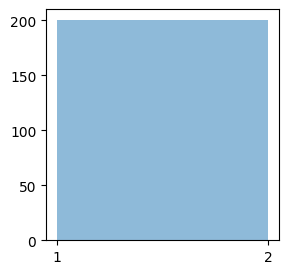

In [3]:
# Z stack
num_z = []
for file_path in IMAGE_DIRS:

    # Open the TIFF file and extract the width and height of each page
    with tifffile.TiffFile(file_path) as tiff:
        num_z.append(len(tiff.pages))

# Create a scatter plot
plt.figure(figsize=(3, 3))
plt.hist(num_z, bins=range(1, max(num_z) + 2), alpha=0.5)
plt.xticks(range(1, max(num_z) + 2))
plt.show()

In [14]:
with tifffile.TiffFile(IMAGE_DIRS[5]) as tiff:
    for i, page in enumerate(tiff.pages):
        # print(page.tags)
        w, h = page.shape[:2]

        # Can't get physical resolution from tif header?
        # Calculation result not sensible: X resolution: 352.78 µm, Y resolution: 352.78 µm
        # x_res = page.tags['XResolution'].value[1] / page.tags['XResolution'].value[0] * 25400  # Convert to micrometers per pixel
        # y_res = page.tags['YResolution'].value[1] / page.tags['YResolution'].value[0] * 25400
        # print(f"Width: {w}, Height: {h}, X resolution: {x_res:.2f} µm, Y resolution: {y_res:.2f} µm")

        break

Width: 520, Height: 696, X resolution: 352.78 µm, Y resolution: 352.78 µm


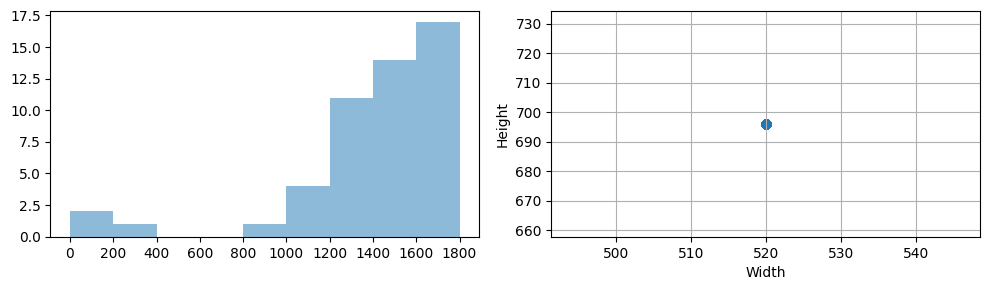

In [4]:
# Lists to store the width and height of each page
widths = []
heights = []
max_values = []

for file_path in IMAGE_DIRS:
    # Open the TIFF file and extract the width and height of each page
    with tifffile.TiffFile(file_path) as tiff:
        w, h = tiff.pages[0].shape[:2]
        widths.append(w)
        heights.append(h)
        max_value = tiff.pages[0].asarray().flatten().max()
        max_values.append(max_value)

# Create scatter plot
figs, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].hist(max_values, bins=range(0, 2000, 200), alpha=0.5)
axes[0].set_xticks(range(0, 2000, 200))
axes[1].scatter(widths, heights, alpha=0.5)
axes[1].set_xlabel('Width')
axes[1].set_ylabel('Height')
axes[1].grid(True)
plt.tight_layout()
plt.show()


In [5]:
# Pack the image information into a DataFrame
df_image_info = pd.DataFrame(
    {
        "file_path": IMAGE_DIRS,
        "max_value": max_values,
        "num_z": num_z,
        "width": widths,
        "height": heights
    }
)
df_image_info["mask_path"] = df_image_info["file_path"].str.replace("images", "masks").str.replace(".tif", ".png")

# df_image_info[df_image_info["max_value"] < 500]
df_image_info.head()

,file_path,max_value,num_z,width,height,mask_path
0,data/images/IXMtest_A02_s1_w1051DAA7C-7042-435...,4095,1,520,696,data/masks/IXMtest_A02_s1_w1051DAA7C-7042-435F...
1,data/images/IXMtest_A06_s6_w1B9577918-4973-4A8...,1998,1,520,696,data/masks/IXMtest_A06_s6_w1B9577918-4973-4A87...
2,data/images/IXMtest_A09_s1_w1CE70AD49-290D-431...,1720,1,520,696,data/masks/IXMtest_A09_s1_w1CE70AD49-290D-4312...
3,data/images/IXMtest_A12_s7_w1EAEEA614-51ED-43B...,3885,1,520,696,data/masks/IXMtest_A12_s7_w1EAEEA614-51ED-43B3...
4,data/images/IXMtest_A15_s5_w1825174D4-ED30-490...,2224,1,520,696,data/masks/IXMtest_A15_s5_w1825174D4-ED30-490C...


#### Mask
* Understand how mask is stored to represent each separate nuclei
    * bbbc039: 
        * 4 channel png: only first channel has value (weirdly very small value)
        * only touching nuclei are marked as different value (i.e. # unique values = 4, ~= # nucleous)
    * dsb2018:
        * single-channel tiff (called "labels", processed masks are called "masks")
        * EACH nuclei is marked by a different value (i.e. # unique values = 29 = # nucleous)

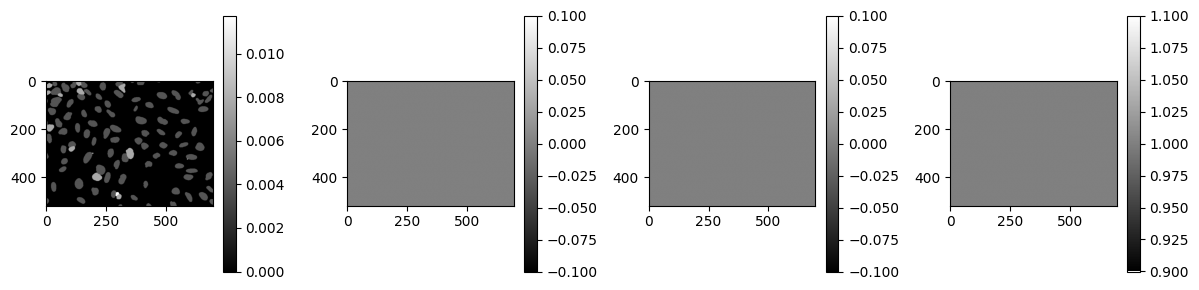

In [17]:
mask_path = "data/masks/IXMtest_A02_s1_w1051DAA7C-7042-435F-99F0-1E847D9B42CB.png"
mask = plt.imread(mask_path)
fig, ax = plt.subplots(1, 4, figsize=(12, 3))
fig.colorbar(ax[0].imshow(mask[:,:,0], cmap='gray'), ax=ax[0])
fig.colorbar(ax[1].imshow(mask[:,:,1], cmap='gray'), ax=ax[1])
fig.colorbar(ax[2].imshow(mask[:,:,2], cmap='gray'), ax=ax[2])
fig.colorbar(ax[3].imshow(mask[:,:,3], cmap='gray'), ax=ax[3])
plt.tight_layout()
plt.show()

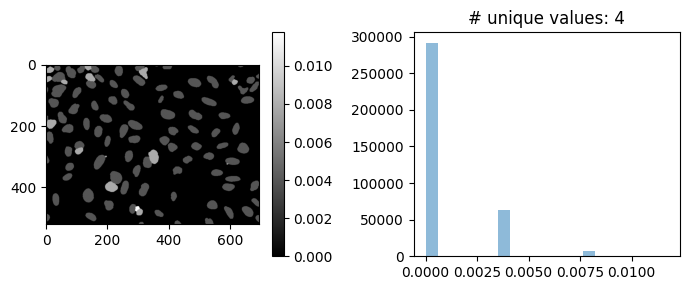

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))
fig.colorbar(ax[0].imshow(mask[:,:,0], cmap='gray'), ax=ax[0])
ax[1].hist(mask[:,:,0].flatten(), bins=20, alpha=0.5)
ax[1].set_title(f"# unique values: {len(np.unique(mask[:,:,0].flatten()))}")
plt.tight_layout()
plt.show()

In [ ]:
# TODO: Count number of nuclei instances:


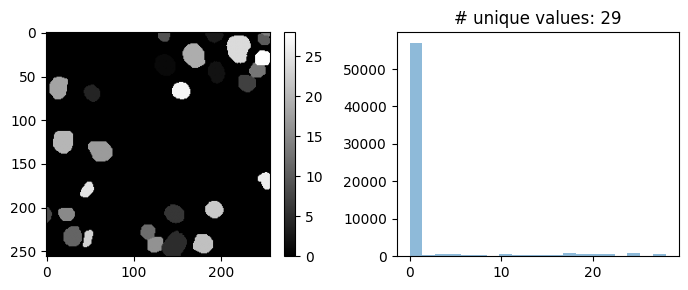

In [ ]:
# Compare with dsb2018
# "label"
mask_path = "/Users/thuang/Documents/Personal/code/dsb2018_topcoders/data/labels_all/0a7d30b252359a10fd298b638b90cb9ada3acced4e0c0e5a3692013f432ee4e9.tif"
mask = plt.imread(mask_path)
# mask.shape
fig, ax = plt.subplots(1, 2, figsize=(7, 3))
fig.colorbar(ax[0].imshow(mask, cmap='gray'), ax=ax[0])
ax[1].hist(mask.flatten(), bins=20, alpha=0.5)
ax[1].set_title(f"# unique values: {len(np.unique(mask.flatten()))}")
plt.tight_layout()
plt.show()

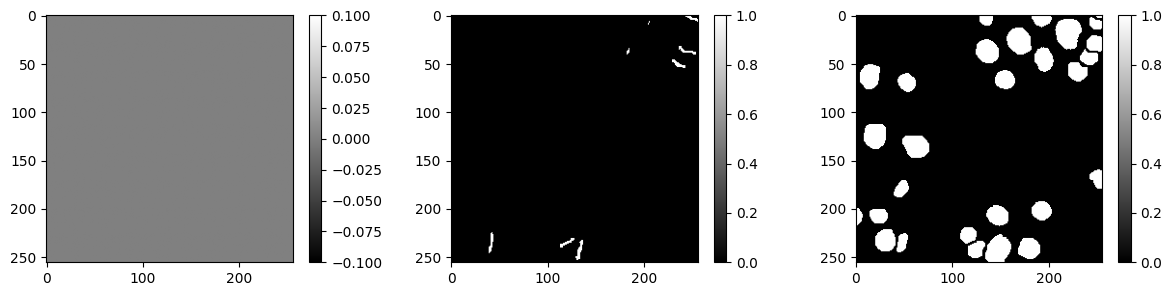

In [13]:
# Compare with dsb2018
# "mask"
mask_path = "/Users/thuang/Documents/Personal/code/dsb2018_topcoders/data/masks_all/0a7d30b252359a10fd298b638b90cb9ada3acced4e0c0e5a3692013f432ee4e9.png"
mask = plt.imread(mask_path)
fig, ax = plt.subplots(1, 3, figsize=(12, 3))
fig.colorbar(ax[0].imshow(mask[:,:,0], cmap='gray'), ax=ax[0])
fig.colorbar(ax[1].imshow(mask[:,:,1], cmap='gray'), ax=ax[1])
fig.colorbar(ax[2].imshow(mask[:,:,2], cmap='gray'), ax=ax[2])
plt.tight_layout()
plt.show()

#### Image viewer
* Outliers: background with no cells

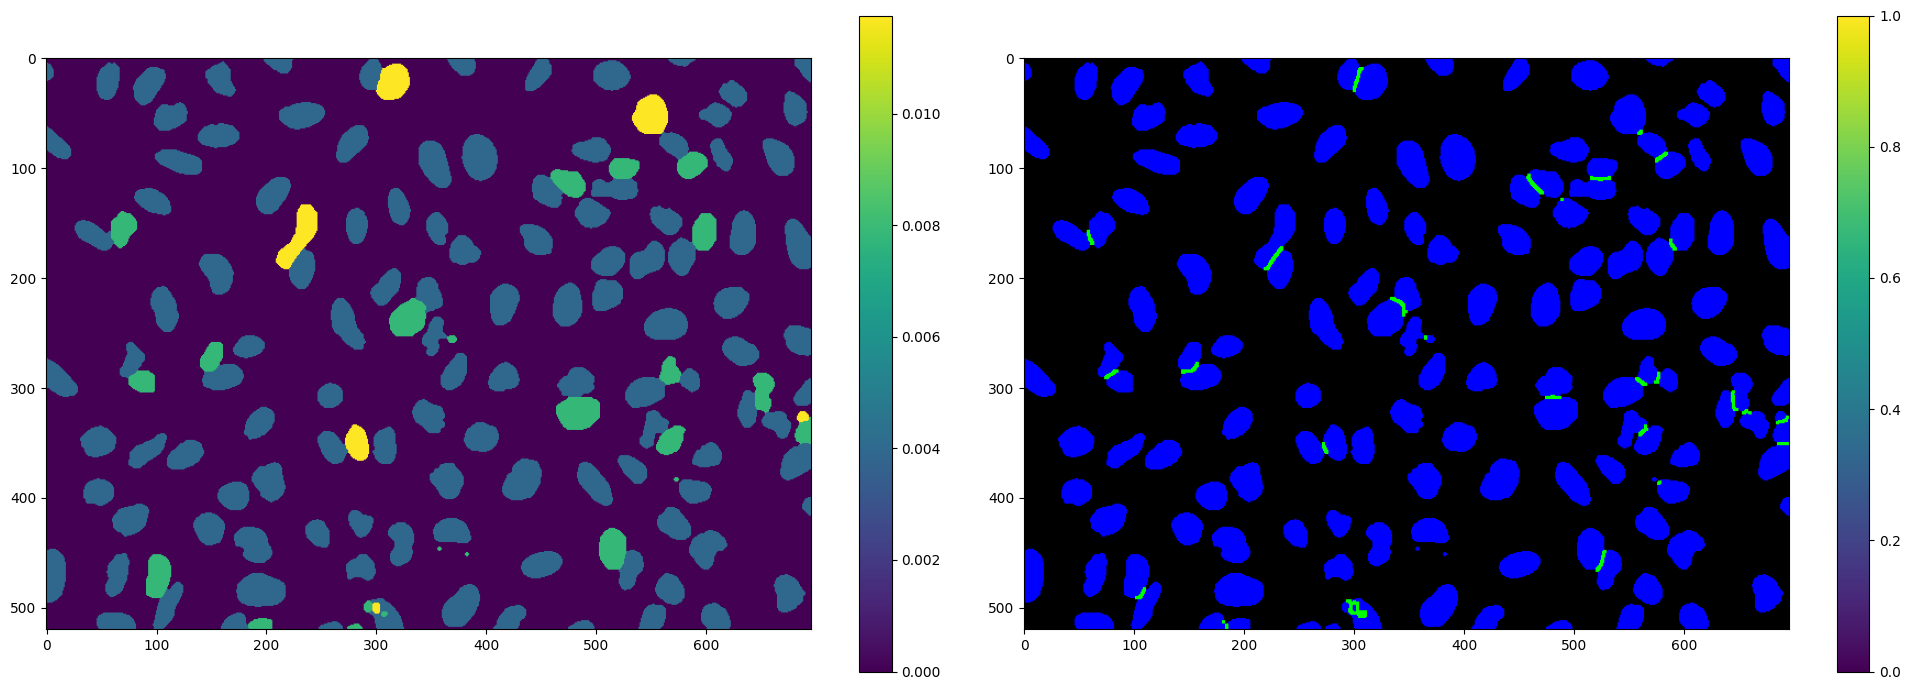

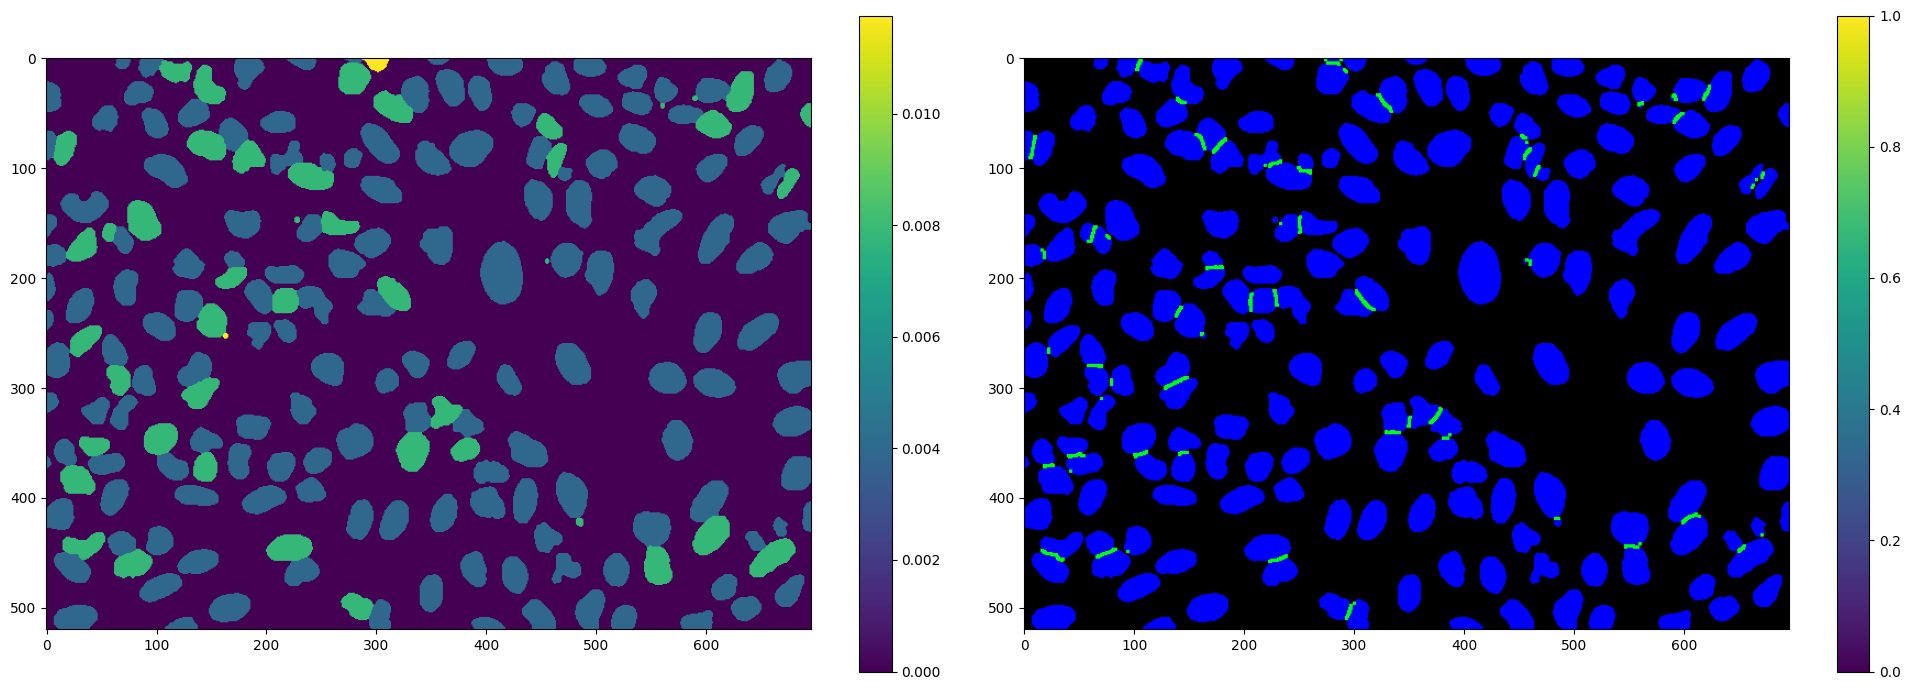

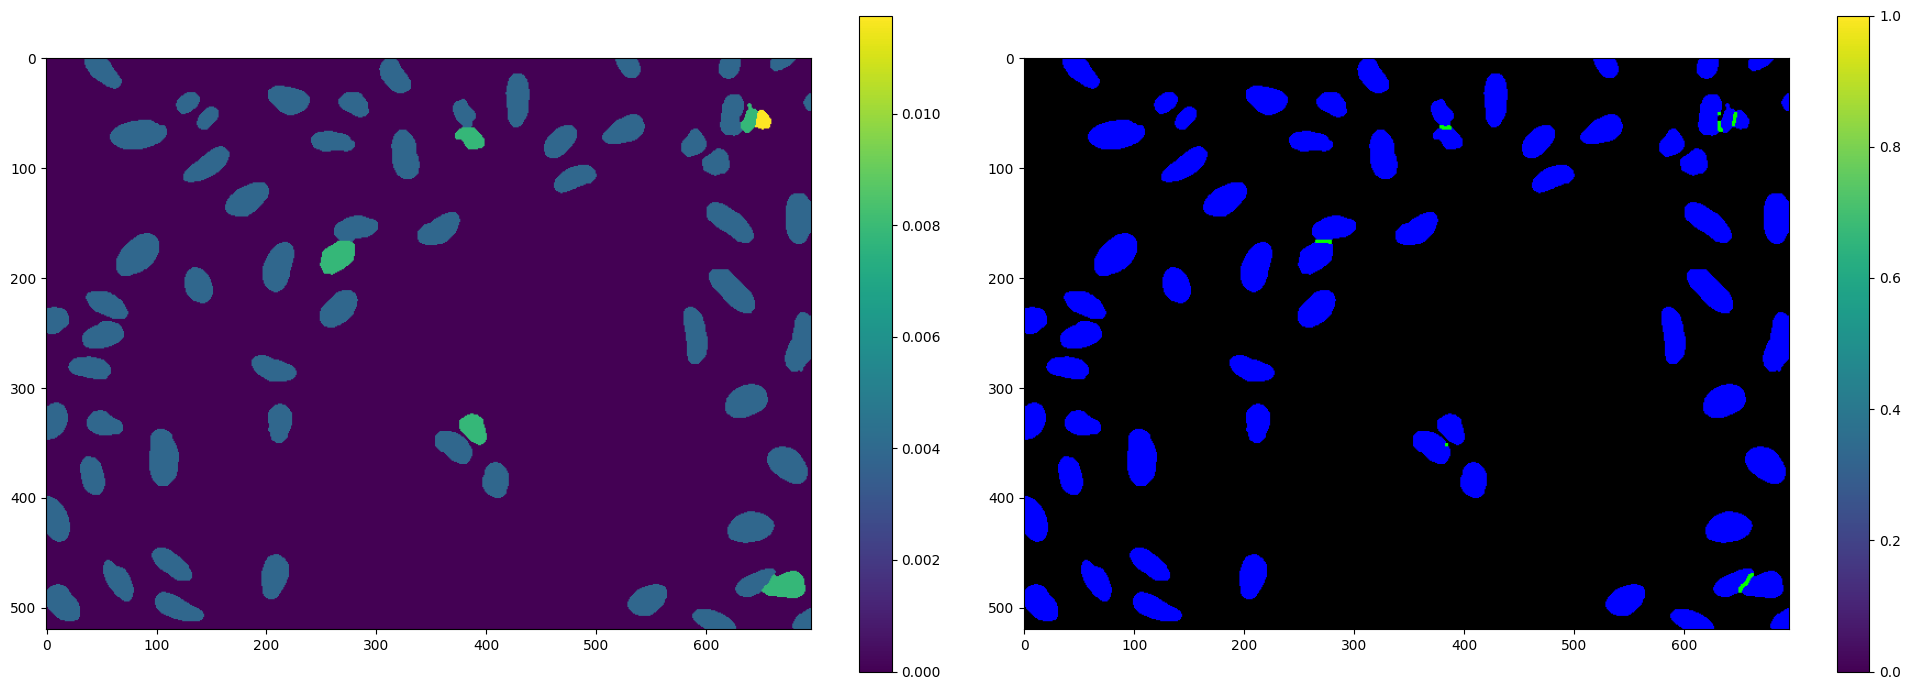

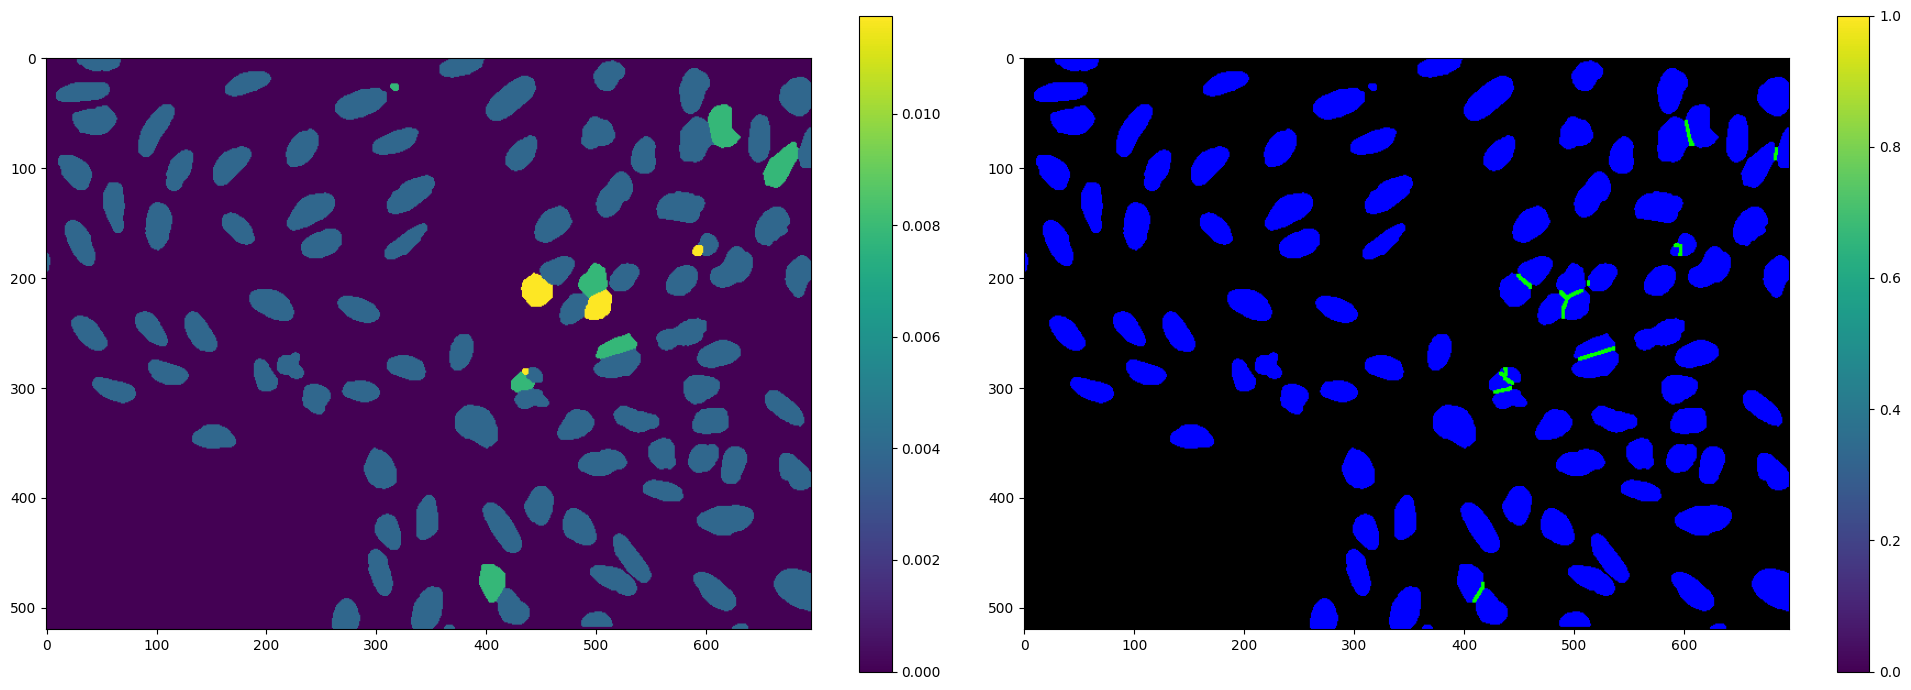

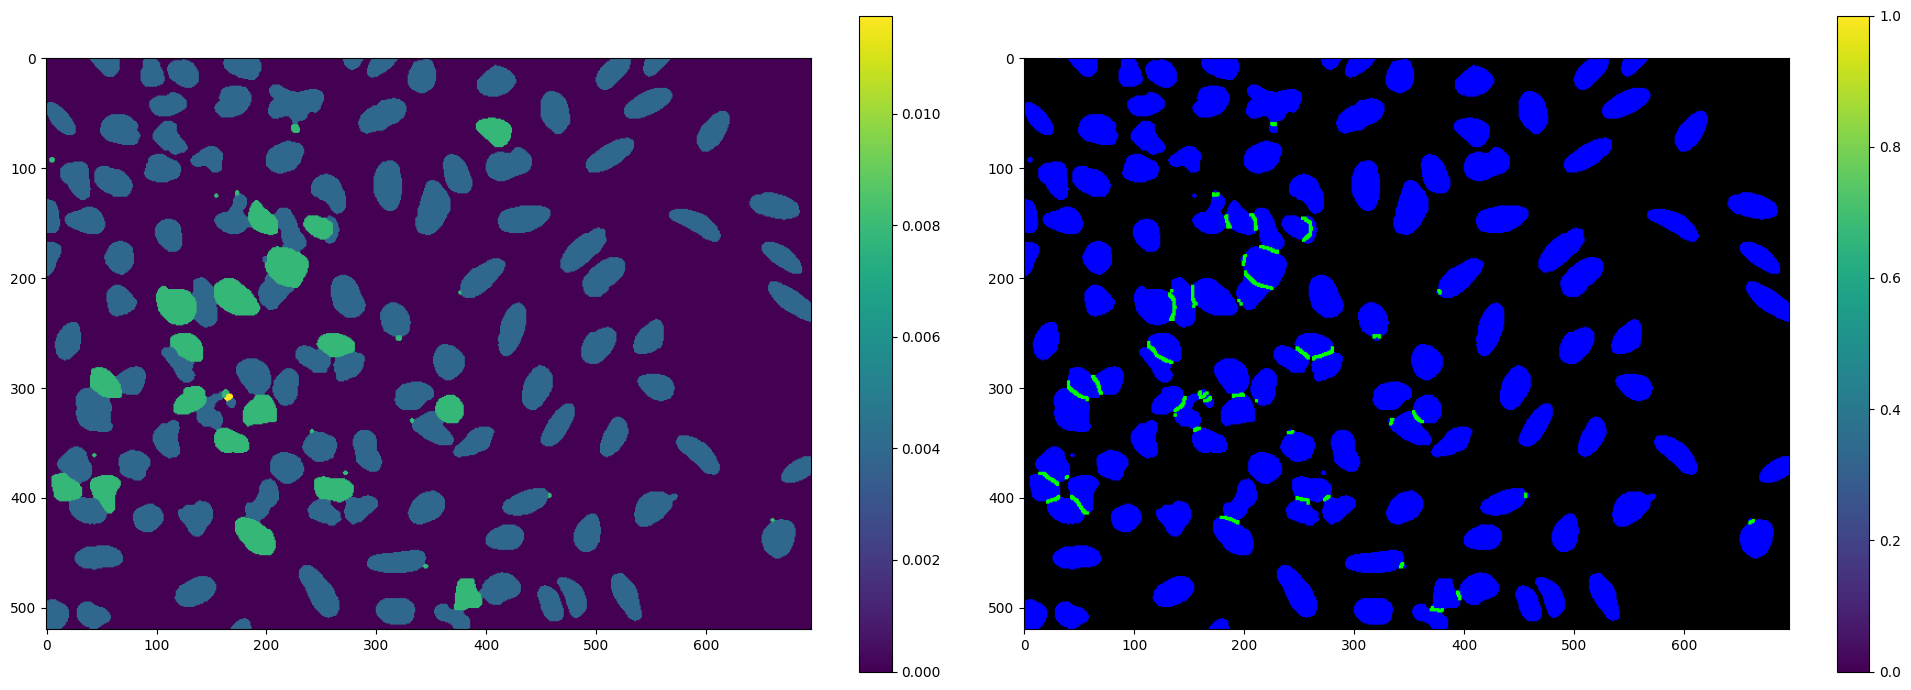

In [ ]:
from notebooks.image_processing import normalize_image, get_gt_mask_png

def view_image(df_image_info):
    for row in df_image_info.itertuples():

        im = plt.imread(row.file_path)
        mask = plt.imread(row.mask_path)

        # Check image normalization and mask processing methods
        
        im = normalize_image(im)
        mask_ = get_gt_mask_png(mask[:,:,0], 1, 1, 3)

        # Visualize
        figs, axes = plt.subplots(1, 2, figsize=(20, 7))
        # figs.colorbar(axes[0].imshow(im, cmap="gray"), ax=axes[0])
        # axes[0].set_title(f"Original Image (dtype: {im.dtype})")

        # axes[1].hist(im.ravel(), bins=20, alpha=0.5)
        # axes[1].set_title("Image Histogram")
        figs.colorbar(axes[0].imshow(mask[:,:,0]), ax=axes[0])
        # axes[0].set_title(f"Original Mask (dtype: {mask.dtype})")

        # figs.colorbar(axes[2].imshow(mask[:,:,0]), ax=axes[2]) # Origginal mask
        figs.colorbar(axes[1].imshow(mask_), ax=axes[1])
        # axes[1].set_title(f"Processed Mask (dtype: {mask_.dtype})")

        # axes[3].hist(mask[:,:,0].ravel(), bins=20, alpha=0.5) # Origginal mask

        plt.tight_layout()
        plt.show()
    return

# Random 5 images to view
view_image(df_image_info.sample(5))

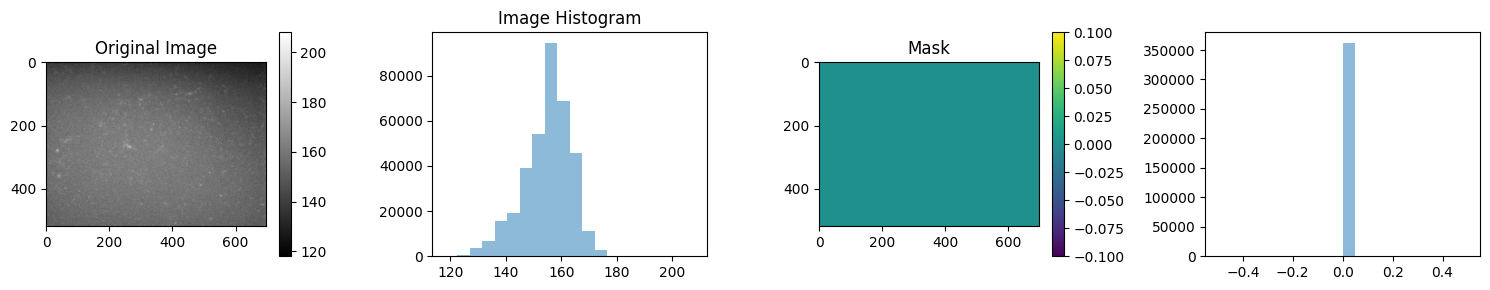

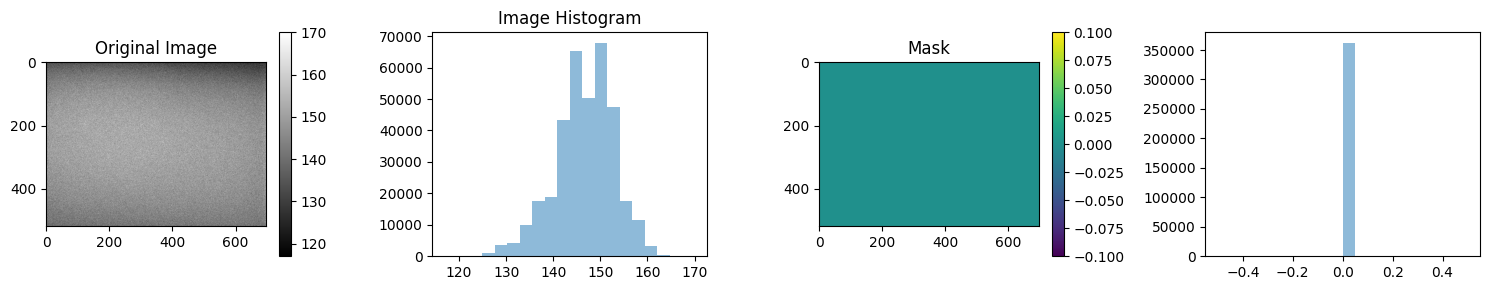

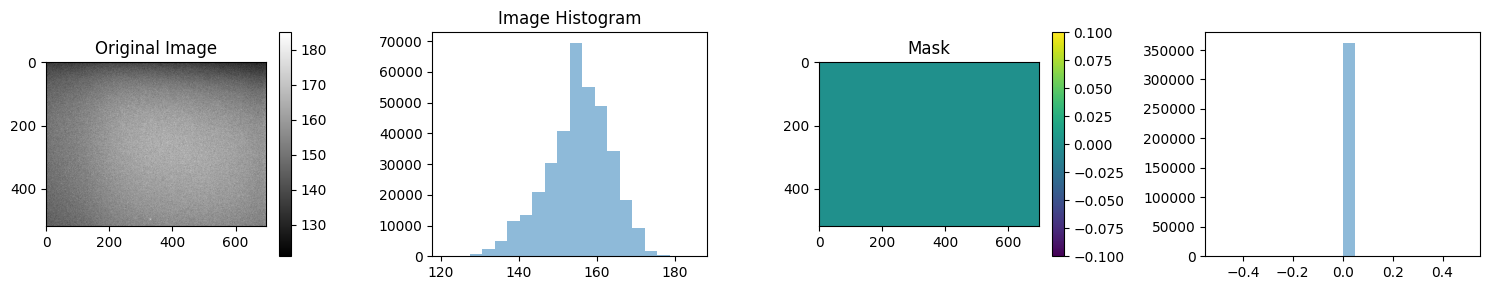

In [91]:
# Background only with no cells
view_image(df_image_info[df_image_info["max_value"] < 500])

#### 1/0 ratio

In [9]:
from notebooks.image_processing import get_gt_mask_png
def count_foreground_background(mask_path, if_split_line=False):
    mask = plt.imread(mask_path)
    mask = mask[:,:,0]
    if if_split_line:
        mask = get_gt_mask_png(mask)[:,:,1] # Get split line mask
    if np.max(mask.flatten()) == 0:
        return (0, mask.size)
    bg_num = np.sum(mask.flatten() == 0.)
    fg_num = np.sum(mask.flatten() > 0.)
    return (fg_num, bg_num)

df_image_info["fg_num_object"], df_image_info["bg_num_object"] = zip(*df_image_info["mask_path"].apply(count_foreground_background))
df_image_info["fg_num_split_line"], df_image_info["bg_num_split_line"] = zip(*df_image_info["mask_path"].apply(lambda x: count_foreground_background(x, if_split_line=True)))
df_image_info.head(1)
# df_image_info["foreground_over_background"] = df_image_info["mask_path"].apply(cal_foreground_over_background)
# df_image_info["foreground_over_background_split_line"] = df_image_info["mask_path"].apply(lambda x: cal_foreground_over_background(x, if_split_line=True))

/Users/thuang/Documents/Personal/code/microscopy-with-ml/notebooks/image_processing.py:15: RuntimeWarning: invalid value encountered in divide
  return (image - np.min(image)) / (np.max(image) - np.min(image))
/Users/thuang/Documents/Personal/code/microscopy-with-ml/notebooks/image_processing.py:19: RuntimeWarning: invalid value encountered in cast
  mask = (normalize_image(mask) * 255.).astype(np.uint8)


,file_path,max_value,num_z,width,height,mask_path,fg_num_object,bg_num_object,fg_num_split_line,bg_num_split_line
0,data/images/IXMtest_A02_s1_w1051DAA7C-7042-435...,4095,1,520,696,data/masks/IXMtest_A02_s1_w1051DAA7C-7042-435F...,70682,291238,1045,360875


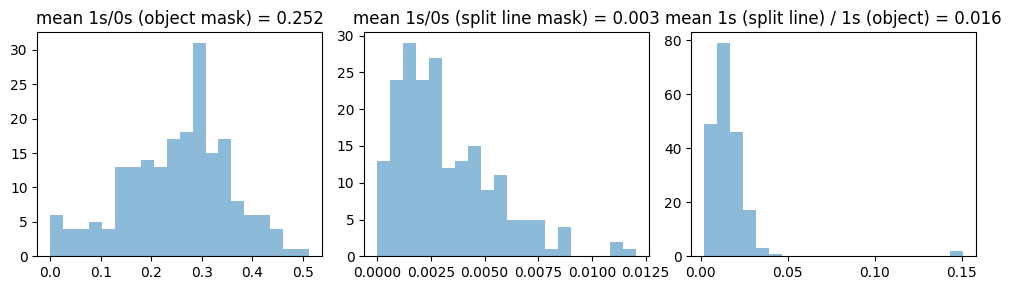

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
ratio_object_mask = df_image_info["fg_num_object"] / df_image_info["bg_num_object"]
ratio_split_line_mask = df_image_info["fg_num_split_line"] / df_image_info["bg_num_split_line"]
ratio_split_line_over_object = df_image_info["fg_num_split_line"] / df_image_info["fg_num_object"]
ax[0].hist(ratio_object_mask, bins=20, alpha=0.5)
ax[0].set_title(f"mean 1s/0s (object mask) = {ratio_object_mask.mean():.3f}")
ax[1].hist(ratio_split_line_mask, bins=20, alpha=0.5)
ax[1].set_title(f"mean 1s/0s (split line mask) = {ratio_split_line_mask.mean():.3f}")
ax[2].hist(ratio_split_line_over_object, bins=20, alpha=0.5)
ax[2].set_title(f"mean 1s (split line) / 1s (object) = {ratio_split_line_over_object.mean():.3f}")
plt.tight_layout()
plt.show()